In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
tf.__version__

'2.1.0'

In [158]:
dataset_path = 'data/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_small/Alison_Lohman_0.npz'
label_path = 'data/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_small.csv'
dataset = np.load(dataset_path)
images = dataset['colorImages']
bb = dataset['boundingBox']

labels = pd.read_csv(label_path)
print(bb[:,:,0])
# bb[:,:,0]=np.flip(bb[:,:,0], 1)
print(bb[:,:,0])

[[ 75.  73.]
 [ 75. 157.]
 [159.  73.]
 [159. 157.]]
[[ 75.  73.]
 [ 75. 157.]
 [159.  73.]
 [159. 157.]]


(228, 213, 3, 240)
(4, 2, 240)


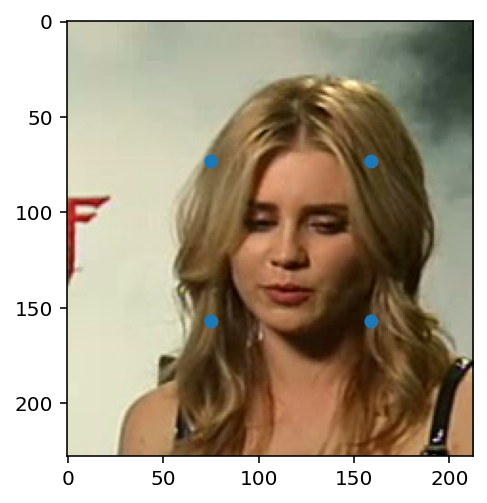

In [195]:
print(images.shape)
print(bb.shape)
plt.scatter(bb[:,:,0][:,0], bb[:,:,0][:,1])
plt.imshow(images[:,:,:,0])

image (240, 228, 213, 3)
bbox (240, 4)
indices (240,)
cropped (240, 192, 192, 3)


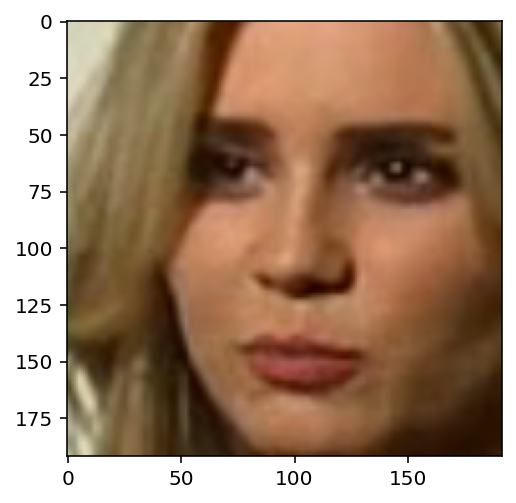

In [205]:
image = np.moveaxis(images, 3, 0)
image = image / 255
_,ys,xs,_ = image.shape
print('image', image.shape)

bbox = np.moveaxis(bb, 2, 0)

# drop topRight and bottmLeft
mask = np.ones_like(bbox, dtype=bool)
mask[:,[1,2]] = False
bbox = bbox[mask].reshape(240, 2, 2)

# normalize
bbox = bbox.transpose()
bbox[0] = bbox[0]/ys
bbox[1] = bbox[1]/xs
bbox = bbox.transpose()

# flatten
bbox = bbox.reshape(240, 4)

print('bbox', bbox.shape)

box_indices = np.array(range(bbox.shape[0]))
print('indices', box_indices.shape)

cropped = tf.image.crop_and_resize(
    image, bbox, box_indices, [192, 192])
print('cropped', cropped.shape)
plt.imshow(cropped[10])

In [212]:

# Load TFLite model and allocate tensors.
facemesh = tf.lite.Interpreter(model_path='data/facemesh/face_landmark.tflite')
facemesh.allocate_tensors()

# Get input and output tensors.
input_details = facemesh.get_input_details()
output_details = facemesh.get_output_details()
print(input_details)
print(output_details)

# Test model on random input data.
test_image = cropped[10]
test_image = np.expand_dims(test_image, 0)
print(test_image.shape)
facemesh.set_tensor(input_details[0]['index'], test_image)

facemesh.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointecatr to the tensor.
output_data = facemesh.get_tensor(output_details[0]['index'])
print(output_data.shape)
landmark = output_data[0][0][0]
print(landmark)

[{'name': 'input_1', 'index': 0, 'shape': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[{'name': 'conv2d_20', 'index': 213, 'shape': array([   1,    1,    1, 1404], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}, {'name': 'conv2d_30', 'index': 210, 'shape': array([1, 1, 1, 1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
(1, 192, 192, 3)
(1, 1, 1, 1404)
[ 97.384155  128.12973   -15.798044  ... 164.35478    65.35999
  -6.1024575]
